In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla
df_nArticlesPerUser = pd.read_pickle("50_posts_data.pkl")

In [2]:
df_nArticlesPerUser

,ID_User,Beitrag
0,28526,vielleicht bin ich da noch etwas zu traditione...
1,28526,also bis zum margaretenplatz finde ich ihn seh...
2,28526,"Das waren schon tolle Romane. Seinerzeit war ""..."
3,28526,Jedenfalls ein interessanter EInblick. Ich emp...
4,28526,Die jetzt kommenden werden zuallererst mal von...
...,...,...
995,18006,"Nein, der UN-Report erwähnt Russland, ebenso w..."
996,18006,Wie schon mehrmals hier bemerkt sind die Abges...
997,18006,Assad hat andere Probleme als Palmyra.Eine gro...
998,18006,"Die Angst, dass Flüchtlinge in Zelten schlafen..."


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=15)
features = tfidf.fit_transform(df_nArticlesPerUser.Beitrag).toarray()
labels = df_nArticlesPerUser.ID_User
features.shape

(1000, 510)

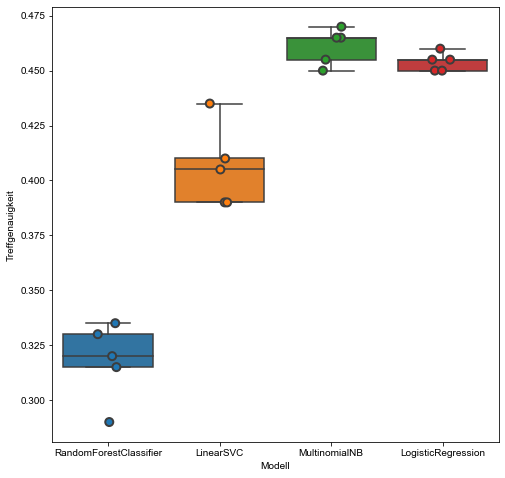

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

models = [
RandomForestClassifier(n_estimators=100),
LinearSVC(),
MultinomialNB(),
LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(8,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(rc={"figure.figsize":(3, 4)})
plt.xlabel('Modell')
plt.ylabel('Treffgenauigkeit')
plt.show()

In [5]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.406
LogisticRegression        0.454
MultinomialNB             0.461
RandomForestClassifier    0.318
Name: accuracy, dtype: float64

In [6]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.290
1,RandomForestClassifier,1,0.335
2,RandomForestClassifier,2,0.330
3,RandomForestClassifier,3,0.320
4,RandomForestClassifier,4,0.315
5,LinearSVC,0,0.435
6,LinearSVC,1,0.405
7,LinearSVC,2,0.390
8,LinearSVC,3,0.410
9,LinearSVC,4,0.390


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

entries = []
for model in models:
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test =train_test_split(features, labels, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    entries.append((model_name, matrix))

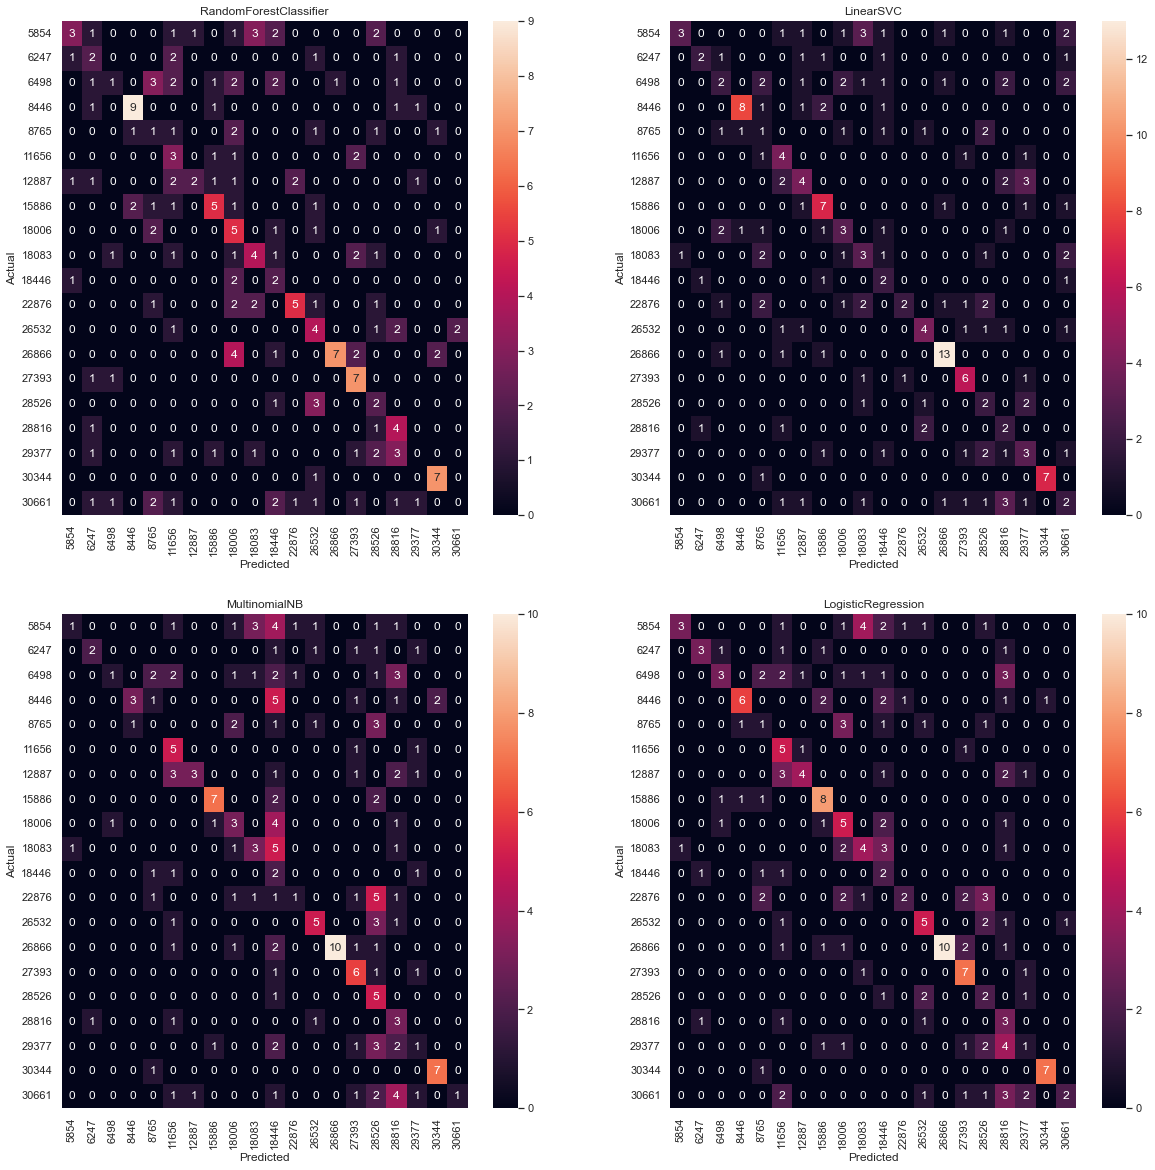

In [9]:
plt.figure(figsize=(20,20))
x = 1
for entry in entries:
    matrix = entry[1]
    plt.subplot(2,2,x)
    ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    
    ax.set(title=entry[0],
      xlabel="Predicted",
      ylabel="Actual",)
    x+=1
    
sns.set(font_scale=1)